In [ ]:
# 1. Imports
import torch, torchvision, os, PIL, pdb
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import gdown, zipfile
from math import ceil

In [ ]:
# 2. Helper functions

def getDevice():
  if torch.cuda.is_available():
    device = 'cuda'
  else:
    device = 'cpu'
  return device

def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

def show(tensor, num):
  data = tensor.detach().cpu()
  #grid = make_grid(denorm(data[:num]), nrow=4).permute(1,2,0)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid) #.clip(0,1)
  plt.show()

In [ ]:
device = getDevice()
noise_dim = 128
#label_dim = 2
batch_size = 256
img_size = 64
img_dim = (img_size, img_size)
img_ch = 1 # greyscale
#lr = 1e-4
epochs = 100
save_step = 900
#embed_size = 100


# Hyperparameters
lr = 0.00025

# logging
wandbact = 0

stats = (0.1307,), (0.3081,)

In [ ]:
# 1. Dataset Class
class MyDataset(Dataset):
  def __init__(self,remove_list, transform = None, train=True):
    self.mnist = datasets.MNIST(root='./data',
                                download=True,
                                train=train,
                                transform=transform)
    self.data = self.mnist.data
    self.targets = self.mnist.targets
    self.transform = transform
    mask = np.ones(len(self.data), dtype=bool)
    mask[remove_list] = False

    self.data = self.data[mask]
    self.targets = self.targets[mask]

  def __getitem__(self, index):
    data, target = self.data[index], self.targets[index]
    data = self.transform(np.array(data))
    return data, target

  def __len__(self):
    return len(self.data)

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([img_size, img_size]),
    #transforms.Normalize((mean_gray,),(stdd_gray,))
])

train_dataset = datasets.MNIST(
    root = 'data',
    download = True,
    train = True,
    transform = transformation
)

test_dataset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformation
)

100%|██████████| 9912422/9912422 [00:00<00:00, 68396628.25it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30909847.88it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23320771.51it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12582912.00it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# remove from mnist all non fives
rem_idx_one = ((train_dataset.targets != 5).nonzero(as_tuple=True)[0])
print(rem_idx_one.shape)

#### USe Only when data augmenting
transformation3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.85, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.Resize([img_size, img_size]),
])

traindat_fives = MyDataset(rem_idx_one, transformation3, True)
print(len(traindat_fives))

# create reduced subset

remove_idx = ((traindat_fives.targets == 5).nonzero(as_tuple=True)[0])
num = remove_idx.shape[0]
num = ceil(0.99 * num)
print(f'num {num}')

to_remove = remove_idx[:num]
to_keep = remove_idx[num:]
print(f'remove_idx.shape {to_keep.shape}')

trainset_1 = torch.utils.data.Subset(traindat_fives, to_keep)

torch.Size([54579])
5421
num 5367
remove_idx.shape torch.Size([54])


2
54


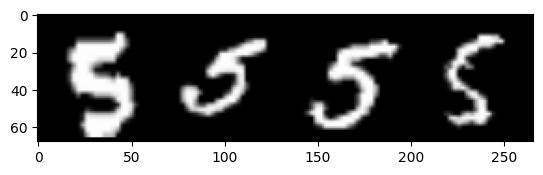

In [ ]:
# 4. Dataset Initialization
batch_size = 32

trainloader = DataLoader(
    #dataset = train_dataset,
    dataset = trainset_1,
    batch_size = batch_size,
    shuffle = True
)

print(len(trainloader))
print(len(trainset_1))
# dataset visualization
ha, labels = next(iter(trainloader))
show(ha, 4)

save the above aumented images

In [ ]:
from torchvision.utils import save_image

num_imgs = 0
j = 0
while num_imgs < 150:
  data, _ = next(iter(trainloader))
  #show(data, batch_size)

  for i in range(len(data)):
    img = data[i]
    img = torch.nn.functional.adaptive_avg_pool2d(img, output_size=28)
    #show(img, 1)
    name = f'{j}{i}.png'
    save_image(img, f'/content/drive/MyDrive/generated_mnist_aug3/{name}')

  num_imgs += batch_size
  j += 1

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
